<a href="https://colab.research.google.com/github/luis0098/Archivos/blob/main/Analisis_Modal_Linkedin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
import numpy as np
from numpy import array
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd

# Datos

In [ ]:
"####################### INPUT ############################"
h = 255 #cm
k = [34078, 20120, 16415, 13872, 9848] #kN/cm
m = [2.9,2.9,2.9,2.9,2.9] #kN-s2/cm
Soil, Zona, U, R = "Rigid", 4, 1.0, 3
Cd = 0.85*R

# Funciones

In [ ]:
"######################### PROGRAM ###############################"
n_stories = len(k)
Sai, Svi, Sdi, Fi, Vb, Vi, di, dri = [], [], [], [], [], [], [], []
"####################### Definitions ###############################"
def Modal_Analysis(n,k,m):
    K = np.zeros((n,n))
    M = np.zeros((n,n))
    prov, modes, me ,T, PF = [], [], [], [], []
    for i in range(n):
        if i < n-1:
            K[i,i],K[i,i+1],K[i+1,i] = k[i]+k[i+1],-k[i+1],-k[i+1]
            M[i,i]   = m[i]
        else:
            K[i,i], M[i,i] = k[i], m[i]
    
    #Eigenvalues and Eigenvectors
    Minv = np.linalg.inv(M)
    A = Minv @ (K)
    eigvals, eigvecs = la.eig(A)
    eigvals = eigvals.real
    omega = np.sqrt(eigvals)

    #Vibration Modes
    eigvecs = np.transpose(eigvecs)
    for i in range(n):
        prov.append(eigvecs[i]/max(max(eigvecs[i]), -min(eigvecs[i])))
        T.append(2*np.pi/omega[n-(i+1)])
    prov = array(prov)

    for i in range(n):
        modes.append(prov[n-(i+1)])
    modes = array(modes)
    #Participation Factor and Effective modal mass Ratio
    for i in range(n):
        PF.append((modes[i] @ M @ np.ones(n))/((modes[i] @ M @ modes[i].reshape(n,1))))
        me.append(((modes[i] @ M @ np.ones(n))**2)/((modes[i] @ M @ modes[i].reshape(n,1))))
    EMMR = me/sum(me)

    return K, M, array(T), omega, modes, EMMR, array(PF)

In [ ]:

def Peru_Response_Spectrum(Tn, Soil, Zona,U,R):
    '''
    Parameters
    ----------
    Soil : String
        Rigid / Intermediate / Flexible
    '''
    if   Zona == 4: Z = 0.45
    elif Zona == 3: Z = 0.35
    elif Zona == 2: Z = 0.25
    else: Z = 0.10
    
    if   Soil == "Rigid": S, Tp, TL = 1, 0.4, 2.5
    elif Soil == "Intermediate" and Z==0.45: S, Tp, TL = 1.05, 0.6, 2.0
    elif Soil == "Flexible"     and Z==0.45: S, Tp, TL = 1.10, 1.0, 1.6
    elif Soil == "Intermediate" and Z==0.35: S, Tp, TL = 1.15, 0.6, 2.0
    elif Soil == "Flexible"     and Z==0.35: S, Tp, TL = 1.20, 1.0, 1.6
    elif Soil == "Intermediate" and Z==0.25: S, Tp, TL = 1.20, 0.6, 2.0
    elif Soil == "Flexible"     and Z==0.25: S, Tp, TL = 1.40, 1.0, 1.6
    elif Soil == "Intermediate" and Z==0.10: S, Tp, TL = 1.60, 0.6, 2.0
    else: S = 2.00, 1.0, 1.6
    
    if   Tn<0.2*Tp: C = 1+7.5*(Tn/Tp)
    elif Tn<Tp:     C = 2.5
    elif Tn<TL:     C = 2.5*(Tp/Tn)
    else:           C = 2.5*((Tp*TL)/Tn**2)
    
    Sa = Z*U*S*C*981/R
    
    return Sa

In [ ]:
def CQC(omega, response, betha = 0.05):
    '''
    Complete Quadratic Combination
    '''
    r = []
    for i in range(n_stories):
        for j in range(n_stories):
            fq_ratio = omega[j]/omega[i]
            rho=(8*betha**2*(1+fq_ratio)*fq_ratio**1.5)/((1-fq_ratio**2)**2+4*betha**2*fq_ratio*(1+fq_ratio)**2)
            r.append(response[i]*rho*response[j])
    r=np.sqrt(sum(r))
            
    return r

# Analisis Modal Espectral

In [ ]:
"####################### Structural Analysis ###############################"
K, M, T, omega, modes, EMMR, PF = Modal_Analysis(n_stories,k,m)
for i in range(n_stories):
    Sai.append(Peru_Response_Spectrum(T[i],Soil,Zona,U,R))
    Svi.append(Sai[i]/(2*np.pi/T[i]))
    Sdi.append(Sai[i]/(2*np.pi/T[i])**2)

for i in range(n_stories):
    Fi.append(Sai[i]*modes[i]*PF[i])
    Vb.append(sum(Sai[i]*modes[i]*PF[i]))
    di.append(Sdi[i]*modes[i]*PF[i])
Fi, di = array(Fi), array(di)*(Cd)

for i in range(n_stories):
    prov, prov2 = [], [di[i][0]]
    for j in range(n_stories):
        prov.append(sum(Fi[i][j:]))
        if j < (n_stories-1):
            prov2.append(di[i][j+1]-di[i][j])
    Vi.append(prov), dri.append(prov2)
Vi, dri = array(Vi), array(dri)*(Cd/h)

V_r  = CQC(omega, Vi,  betha = 0.05)
D_r  = CQC(omega, di,  betha = 0.05)
SD_r = CQC(omega, dri, betha = 0.05)

# Graficos

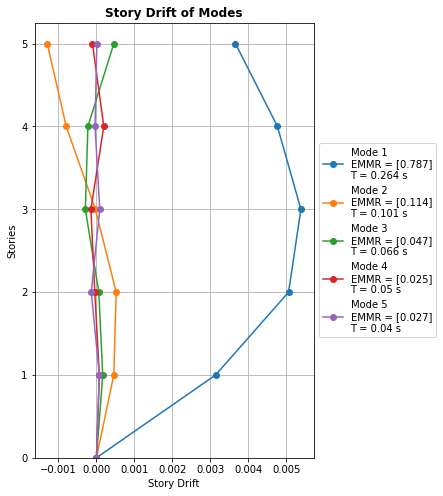

In [ ]:
#@title
"####################### Graphs ###############################"
'###### Modes #####'
label = ['Mode '+str(i+1)+'\nEMMR = '+str(np.round(EMMR[i],3))+
                      '\nT = '+str(round(T[i],3))+' s' for i in range(n_stories)]

fig, ax = plt.subplots(figsize=(5, 8))
plt.title('Story Drift of Modes',fontweight="bold")
X=np.reshape(np.append(np.zeros(n_stories), np.transpose(dri)),(n_stories+1,n_stories))
Y=np.transpose([np.linspace(0,n_stories,n_stories+1)]*n_stories)
ax.plot(X,Y, 'o-'), ax.grid(), ax.legend(label,loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('Story Drift'), plt.ylabel('Stories')
ax.set(ylim=(0))
plt.show()

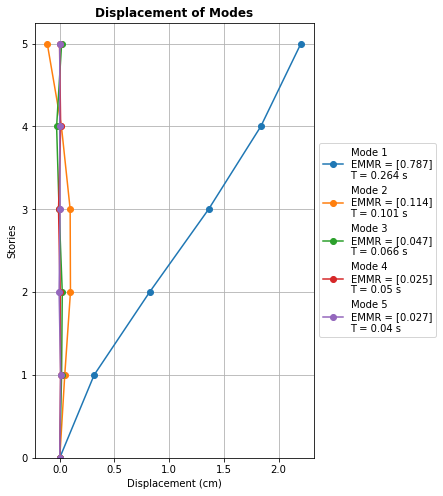

In [ ]:
#@title
fig, ax2 = plt.subplots(figsize=(5, 8))
plt.title('Displacement of Modes',fontweight="bold")
X=np.reshape(np.append(np.zeros(n_stories), np.transpose(di)),(n_stories+1,n_stories))
Y=np.transpose([np.linspace(0,n_stories,n_stories+1)]*n_stories)
ax2.plot(X,Y, 'o-'), ax2.grid(), ax2.legend(label,loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('Displacement (cm)'), plt.ylabel('Stories')
ax2.set(ylim=(0))
plt.show()

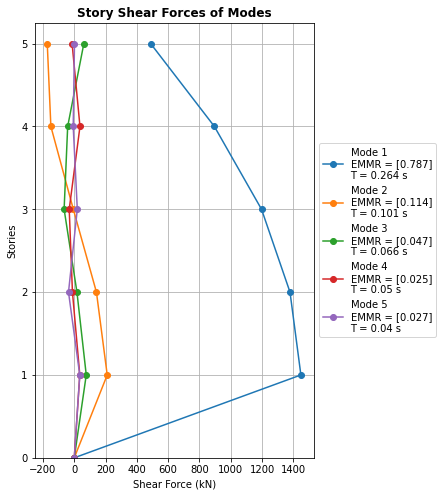

In [ ]:
#@title
fig, ax3 = plt.subplots(figsize=(5, 8))
plt.title('Story Shear Forces of Modes',fontweight="bold")
X=np.reshape(np.append(np.zeros(n_stories), np.transpose(Vi)),(n_stories+1,n_stories))
Y=np.transpose([np.linspace(0,n_stories,n_stories+1)]*n_stories)
ax3.plot(X,Y, 'o-'), ax3.grid(), ax3.legend(label,loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('Shear Force (kN)'), plt.ylabel('Stories')
ax3.set(ylim=(0))
plt.show()

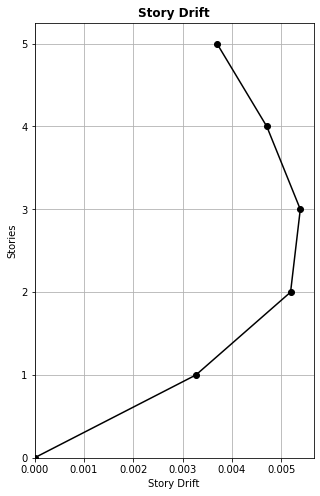

In [ ]:
#@title
'############ Structural Responses ###############'
fig, ax = plt.subplots(figsize=(5, 8))
plt.title('Story Drift',fontweight="bold")
X=np.reshape(np.append(0, np.transpose(SD_r)),(n_stories+1,1))
Y=np.transpose([np.linspace(0,n_stories,n_stories+1)])
ax.plot(X,Y, 'ko-', label=label), ax.grid()
plt.xlabel('Story Drift'), plt.ylabel('Stories')
ax.set(ylim=(0),xlim=(0))
plt.show()

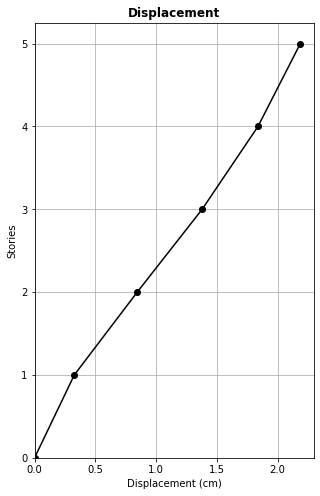

In [ ]:
#@title
fig, ax2 = plt.subplots(figsize=(5, 8))
plt.title('Displacement',fontweight="bold")
X=np.reshape(np.append(0, np.transpose(D_r)),(n_stories+1,1))
Y=np.transpose([np.linspace(0,n_stories,n_stories+1)])
ax2.plot(X,Y, 'ko-'), ax2.grid()
plt.xlabel('Displacement (cm)'), plt.ylabel('Stories')
ax2.set(ylim=(0),xlim=(0))
plt.show()

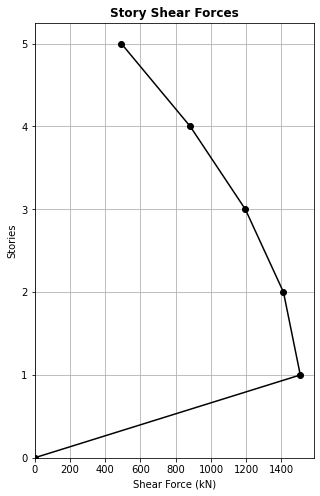

In [ ]:
#@title
fig, ax3 = plt.subplots(figsize=(5, 8))
plt.title('Story Shear Forces',fontweight="bold")
X=np.reshape(np.append(0, np.transpose(V_r)),(n_stories+1,1))
Y=np.transpose([np.linspace(0,n_stories,n_stories+1)])
ax3.plot(X,Y, 'ko-'), ax3.grid()
plt.xlabel('Shear Force (kN)'), plt.ylabel('Stories')
ax3.set(ylim=(0),xlim=(0))
plt.show()

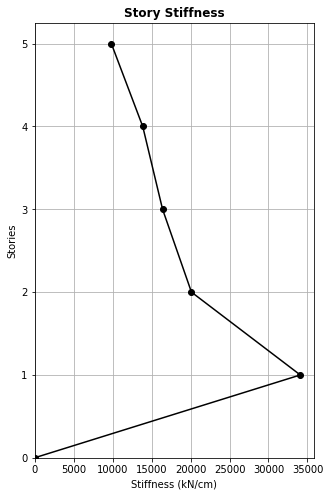

In [ ]:
#@title
fig, ax4 = plt.subplots(figsize=(5, 8))
plt.title('Story Stiffness',fontweight="bold")
X=np.reshape(np.append(0, np.transpose(k)),(n_stories+1,1))
Y=np.transpose([np.linspace(0,n_stories,n_stories+1)])
ax4.plot(X,Y, 'ko-'), ax4.grid()
plt.xlabel('Stiffness (kN/cm)'), plt.ylabel('Stories')
ax4.set(ylim=(0),xlim=(0))
plt.show()

# Espectro de diseño

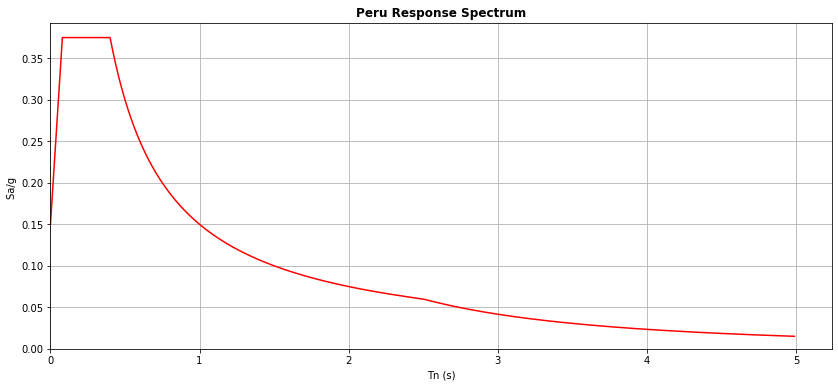

In [ ]:
#@title
Tn_values=np.arange(0,5,0.01)
Sa=[]
for t in Tn_values:
    Sa.append(Peru_Response_Spectrum(t,Soil,Zona,U,R))
Sa=np.array(Sa)/981       
fig, ax4 = plt.subplots(figsize=(14, 6))
plt.title('Peru Response Spectrum',fontweight="bold")
X=Tn_values
Y=Sa
ax4.plot(X,Y,'r-')
ax4.grid()
plt.xlabel('Tn (s)') 
plt.ylabel('Sa/g ')
ax4.set(xlim=(0), ylim=(0))
plt.show()


*   Matriz de Rigidez
*   Matriz de Masas
*   Informacion Modal







In [ ]:
#@title
print("Matriz de Rigidez:\n\n",K)
print("\n"+75*"#"+"\n")
print("Matriz de Masas:\n\n",K)
print("\n"+75*"#"+"\n")

redon=4   #factor de redondeo
modes = ['Mode '+ str(i+1) for i in range(n_stories)]
EMMR = ([(np.round(EMMR[i],redon)) for i in range(n_stories)])       #Effective modal mass Ratio
EMMR_acum=np.zeros(n_stories)
for i in range(n_stories):
    if i ==0:
        EMMR_acum[i]=EMMR[i]
    else:
        EMMR_acum[i]=EMMR_acum[i-1]+EMMR[i]
df=pd.DataFrame({"Period Sec":np.round(T,redon),"Mass Ratio X":EMMR,"Mass Ratio Acum. X":np.round(EMMR_acum,3)},index=modes)
df.round(redon)

Matriz de Rigidez:

 [[ 54198. -20120.      0.      0.      0.]
 [-20120.  36535. -16415.      0.      0.]
 [     0. -16415.  30287. -13872.      0.]
 [     0.      0. -13872.  23720.  -9848.]
 [     0.      0.      0.  -9848.   9848.]]

###########################################################################

Matriz de Masas:

 [[ 54198. -20120.      0.      0.      0.]
 [-20120.  36535. -16415.      0.      0.]
 [     0. -16415.  30287. -13872.      0.]
 [     0.      0. -13872.  23720.  -9848.]
 [     0.      0.      0.  -9848.   9848.]]

###########################################################################



,Period Sec,Mass Ratio X,Mass Ratio Acum. X
Mode 1,0.2643,[0.7872],0.787
Mode 2,0.1013,[0.1145],0.902
Mode 3,0.0657,[0.0466],0.948
Mode 4,0.0502,[0.0247],0.973
Mode 5,0.0405,[0.0271],1.000
